In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids[:1]:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None


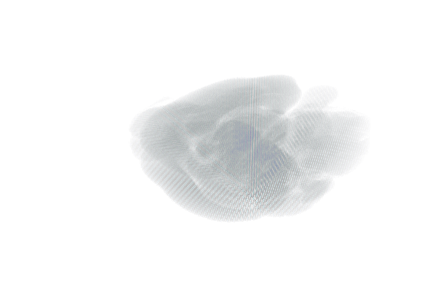

In [325]:
from mpl_toolkits.mplot3d import Axes3D
import random


#plt.show()


<IPython.core.display.Javascript object>


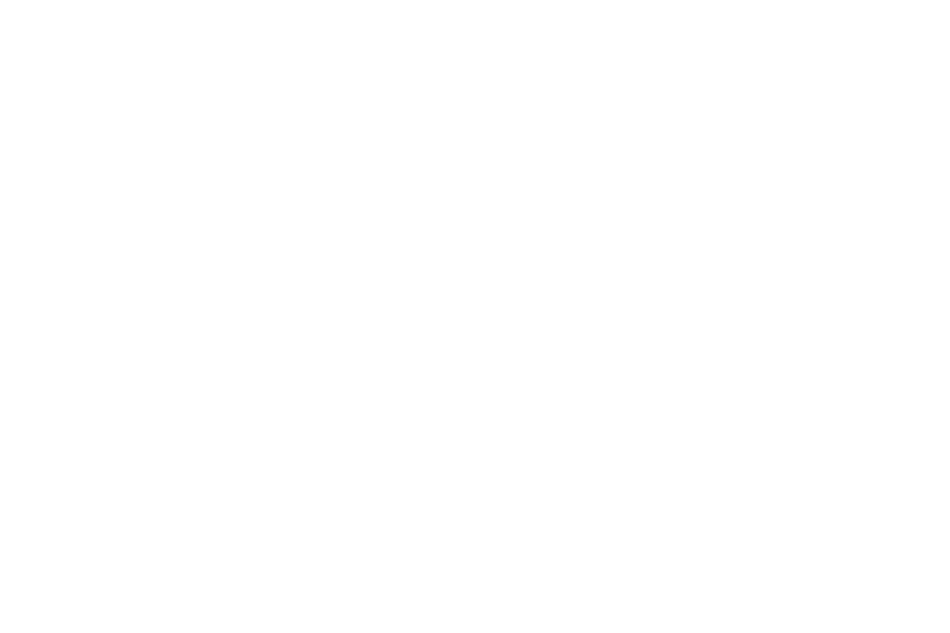

<IPython.core.display.Javascript object>


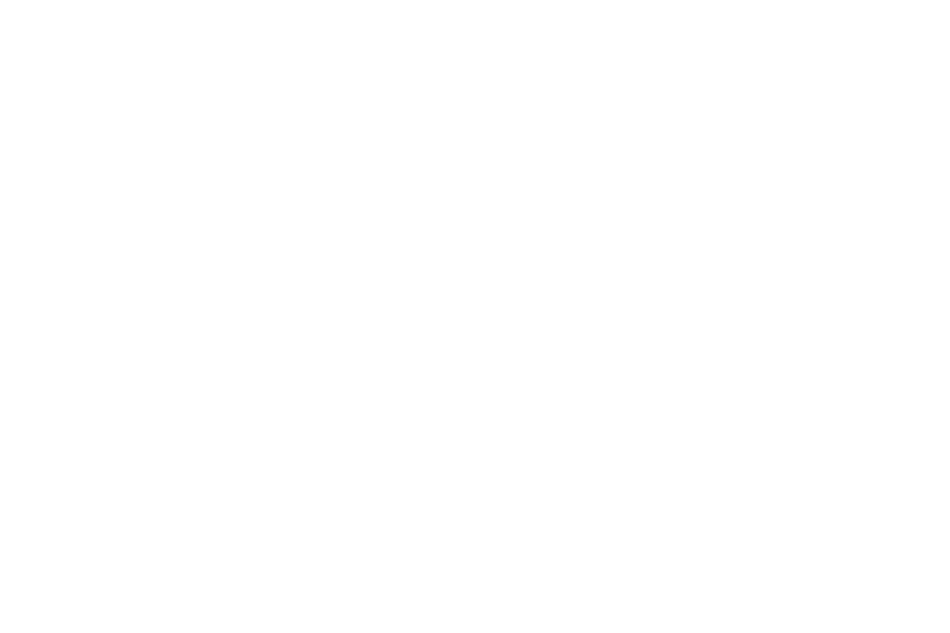

In [368]:
%matplotlib notebook
#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

# ax.scatter(msvds[sid].projection_mask.coordinates[:,0], 
#            msvds[sid].projection_mask.coordinates[:,1], 
#            msvds[sid].projection_mask.coordinates[:,2], alpha = .01, s = .1)

nvox = msvds[sid].projections.shape[1]
proj_colors = np.zeros((nvox,4))
proj_colors[:,0] = 1.0
proj_colors[:, 3] = msvds[sid].projections[0] / msvds[sid].projections[0].max()

ax.scatter(msvds[sid].projection_mask.coordinates[:,0], 
           msvds[sid].projection_mask.coordinates[:,1], 
           msvds[sid].projection_mask.coordinates[:,2], s= .1, c= proj_colors)

nvox = msvds[sid].injections.shape[1]
inj_colors = np.zeros((nvox,4))
inj_colors[:,1] = 1.0
inj_colors[:, 3] = msvds[sid].injections[0] / msvds[sid].injections[0].max()


ax.scatter(msvds[sid].injection_mask.coordinates[:,0], 
           msvds[sid].injection_mask.coordinates[:,1], 
           msvds[sid].injection_mask.coordinates[:,2], s= 1, c= inj_colors)

ax.set_axis_off()

array([[ 88,  63,  73],
       [ 89,  58,  75],
       [ 89,  60,  76],
       ...,
       [131,  50,  59],
       [131,  50,  60],
       [131,  50,  61]])

In [5]:
# from mcmodels.core import Experiment
# exp = Experiment.from_cache(mcc,158375425)#cache, 158375425)
# injection = exp.get_injection(True)
# projection = exp.get_projection(True)

In [4]:
injection = msvds[sid].injections[0]
projection = msvds[sid].projections[0]

In [6]:
a = np.where(injection !=0 )[0]

In [8]:
injection.shape

(27220,)

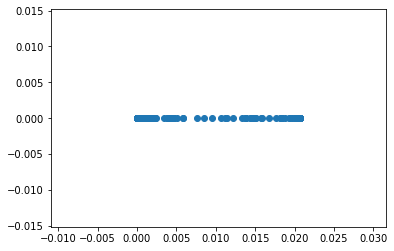

In [7]:
%matplotlib inline
plt.scatter(injection[a], projection[a])

In [ ]:
np.where(injection != 0)[0]

In [39]:
data_volumes = _pull_grid_data(cache, 158375425)

In [68]:
data_mask_tolerance = 0.

In [69]:
from functools import partial

In [70]:
_compute_true_injection_density(data_volumes["injection_density"],
                                data_volumes["injection_fraction"],
                                inplace=True)

# mask data in place
mask_func = partial(_mask_data_volume,
                    data_mask=data_volumes["data_mask"],
                    tolerance=data_mask_tolerance)

injection_density = mask_func(data_volumes["injection_density"])
projection_density = mask_func(data_volumes["projection_density"])

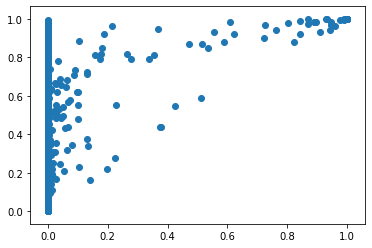

In [71]:
plt.scatter(injection_density, projection_density)

In [10]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import os
import allensdk.core.json_utilities as ju
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')

mcc = MouseConnectivityCache(manifest_file = manifest_file, resolution = 100)

inj = mcc.get_injection_density(158375425)[0]

frac = mcc.get_injection_fraction(158375425)[0]

data_mask = mcc.get_data_mask(158375425)[0]

injfrac = inj*frac*data_mask

proj = mcc.get_projection_density(158375425)[0]

#plt.figure()

#plt.scatter(injfrac, injection)

2020-08-17 15:23:27,366 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/158375425?image=injection_density&resolution=100
2020-08-17 15:23:27,487 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/158375425?image=injection_fraction&resolution=100
2020-08-17 15:23:27,590 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/158375425?image=data_mask&resolution=100
2020-08-17 15:23:27,708 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/158375425?image=projection_density&resolution=100


In [12]:
exp = Experiment.from_cache(mcc, 158375425)

In [7]:
import numpy as np
np.where(injfrac !=0)[0].shape

(482,)

In [8]:
mcc.

(132, 80, 114)

In [3]:
import matplotlib.pyplot as plt

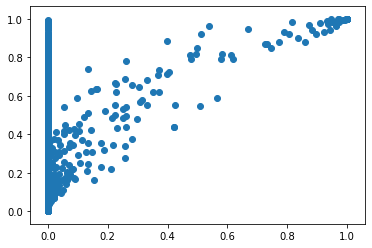

In [11]:
plt.scatter(injfrac, proj)

In [24]:
np.asarray(np.where(injfrac != 0.)).transpose()[:300]

array([[66,  6, 77],
       [66,  7, 76],
       [66,  7, 77],
       [66,  8, 76],
       [66,  8, 77],
       [66,  9, 77],
       [66, 19, 75],
       [66, 19, 76],
       [66, 20, 75],
       [66, 20, 76],
       [66, 21, 76],
       [66, 21, 77],
       [66, 22, 76],
       [66, 22, 77],
       [66, 23, 76],
       [66, 23, 77],
       [66, 24, 76],
       [66, 24, 77],
       [66, 25, 76],
       [66, 25, 77],
       [67,  6, 77],
       [67,  7, 76],
       [67,  7, 77],
       [67,  7, 78],
       [67,  8, 76],
       [67,  8, 77],
       [67,  9, 76],
       [67,  9, 77],
       [67, 10, 76],
       [67, 10, 77],
       [67, 11, 76],
       [67, 12, 76],
       [67, 12, 77],
       [67, 13, 75],
       [67, 13, 76],
       [67, 13, 77],
       [67, 14, 75],
       [67, 14, 76],
       [67, 15, 75],
       [67, 15, 76],
       [67, 19, 75],
       [67, 19, 76],
       [67, 20, 75],
       [67, 20, 76],
       [67, 20, 77],
       [67, 21, 76],
       [67, 21, 77],
       [67, 2

In [20]:
msvds[sid].injection_mask.coordinates[np.where(injfrac != 0.)]

IndexError: too many indices for array

In [42]:
a,b = cache.get_injection_density(158375425)

In [45]:
c,d = cache.get_projection_density(158375425)

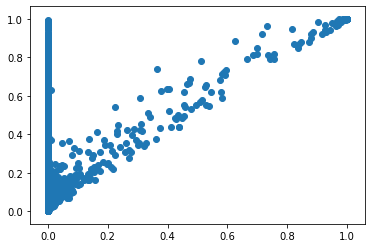

In [47]:
plt.scatter(a,c)

In [ ]:
mcc.get_ex

In [64]:
help(cache.get_data_mask)

Help on method get_data_mask in module allensdk.core.mouse_connectivity_cache:

get_data_mask(experiment_id, file_name=None) method of mcmodels.core.voxel_model_cache.VoxelModelCache instance
    Read a data mask volume for a single experiment. Download it
    first if it doesn't exist.  Data mask is a binary mask of
    voxels that have valid data.  Only use valid data in analysis!
    
    Parameters
    ----------
    
    experiment_id: int
        ID of the experiment to download/read.  This corresponds to
        section_data_set_id in the API.
    
    file_name: string
        File name to store the template volume.  If it already exists,
        it will be read from this file.  If file_name is None, the
        file_name will be pulled out of the manifest.  Default is None.



In [13]:
m  =mcc.get_source_mask()

AttributeError: 'MouseConnectivityCache' object has no attribute 'get_source_mask'

In [74]:
m  =cache.get_source_mask()

In [76]:
np.where(m.mask

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [72]:
help(cache.get_source_mask)

Help on method get_source_mask in module mcmodels.core.voxel_model_cache:

get_source_mask(file_name=None) method of mcmodels.core.voxel_model_cache.VoxelModelCache instance
    Get source mask for voxel-scale model from cache.
    
    Parameters
    ----------
    file_name: string, optional (default=None)
        File name to store the voxel model source_mask.  If it already exists,
        it will be read from this file.  If file_name is None, the
        file_name will be pulled out of the manifest.  Default is None.
    
    Returns
    -------
    Mask object.



In [63]:
cache.get_data_mask(158375425)[0]

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.04      ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.044     ],
        [0.        , 0.        , 0.        , ..., 0.04      ,
         0.041     , 0.09500001]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.1       ],
        [0. 

In [52]:

def _mask_data_volume(data_volume, data_mask, tolerance=0.0):
    """Masks a given data volume in place.

    Parameters
    ----------
    data_volume : array, shape (x_ccf, y_ccf, z_ccf)
        Data volume to be masked.

    data_mask : array, shape (x_ccf, y_ccf, z_ccf)
        data_mask for given experiment (values in [0,1])
        See allensdk.core.mouse_connectivity_cache for more info.

    tolerance : float, optional (default=0.0)
        tolerance with which to define bad voxels in data_mask.


    Returns
    -------
    data_volume
        data_volume parameter masked in place.

    """
    if data_volume.shape != data_mask.shape:
        raise ValueError("data_volume (%s) and data_mask (%s) must be the same "
                         "shape!" % (data_volume.shape, data_mask.shape))

    # mask data volume
    data_volume[data_mask < tolerance] = 0.0

    return data_volume


def _compute_true_injection_density(injection_density, injection_fraction, inplace=False):
    """Computes 'true' injection_density.

    Takes into consideration injection fracion (proportion of pixels in the
    annotated injection site).

    Parameters
    ----------
    injection_density : array, shape (x_ccf, y_ccf, z_ccf)
        injection_density data volume.

    injection_fraction : array, shape (x_ccf, y_ccf, z_ccf)
        injection_fraction data volume.

    inplace : boolean
        If True, overwrites injection_density parameter, else returns new array.

    Returns
    -------
    array, shape (x_ccf, y_ccf, z_ccf)
        'true' injection density : injection_density * injection_fraction
    """
    if injection_density.shape != injection_fraction.shape:
        raise ValueError("injection_density (%s) and injection_fraction "
                         "(%s) must be the same shape!"
                         % (injection_density.shape, injection_fraction.shape))

    if inplace:
        np.multiply(injection_density, injection_fraction, injection_density)
        return injection_density

    return np.multiply(injection_density, injection_fraction)


def _pull_grid_data(cache, experiment_id):
    """Pulls data volumes using VoxelModelCache object.

    Parameters
    ----------
    cache : VoxelModelCache or MouseConnectivityCache instance.
        Object used to pull grid data.

    experiment_id : int
        Experiment id of the experiment from which to pull grid data.

    Returns
    -------
    dict
        Container of relevant data volumes.
        See allensdk.core.mouse_connectivity_cache for description of volumes.

    Notes
    -----
    voxel_model_cache.get_<data_volume> returns a tuple (data_volume, meta_data).
    We only care about the data volume.

    """
    return {
        "data_mask" : cache.get_data_mask(experiment_id)[0],
        "injection_density" : cache.get_injection_density(experiment_id)[0],
        "injection_fraction" : cache.get_injection_fraction(experiment_id)[0],
        "projection_density" : cache.get_projection_density(experiment_id)[0]
    }


In [80]:
help(cache.get_data_mask)

Help on method get_data_mask in module allensdk.core.mouse_connectivity_cache:

get_data_mask(experiment_id, file_name=None) method of mcmodels.core.voxel_model_cache.VoxelModelCache instance
    Read a data mask volume for a single experiment. Download it
    first if it doesn't exist.  Data mask is a binary mask of
    voxels that have valid data.  Only use valid data in analysis!
    
    Parameters
    ----------
    
    experiment_id: int
        ID of the experiment to download/read.  This corresponds to
        section_data_set_id in the API.
    
    file_name: string
        File name to store the template volume.  If it already exists,
        it will be read from this file.  If file_name is None, the
        file_name will be pulled out of the manifest.  Default is None.



In [36]:
help(exp.get_injection)

Help on method get_injection in module mcmodels.core.experiment:

get_injection(normalized=False) method of mcmodels.core.experiment.Experiment instance



In [18]:
im = msvds[sid].experiments[158375425].injection_mask
pm = msvds[sid].experiments[158375425].projection_mask
vals1 = im.coordinates
vals2 = pm.coordinates
output = np.zeros(vals1.shape[0])
for i in range(output.shape[0]):
    print(i)
    #print(i)
    output[i] =np.where((vals2[:,0] == vals1[i,0]) & (vals2[:,1]==vals1[i,1]) & (vals2[:,2]==vals1[i,2]))[0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111


3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882


5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617


7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
7370
7371
7372
7373
7374
7375
7376
7377
7378
7379
7380
7381
7382
7383
7384
7385
7386
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398
7399
7400
7401


8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968
8969
8970
8971
8972
8973
8974
8975
8976
8977
8978
8979
8980
8981
8982
8983
8984
8985
8986
8987
8988
8989
8990
8991
8992
8993
8994
8995
8996
8997
8998
8999
9000
9001
9002
9003
9004
9005
9006
9007
9008
9009
9010
9011
9012
9013
9014
9015
9016
9017
9018
9019
9020
9021
9022
9023
9024
9025
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059


In [21]:
injection = im.mask_volume(msvds[sid].experiments[158375425].get_injection(True))
projection = pm.mask_volume(msvds[sid].experiments[158375425].get_projection(True))

In [29]:
%matplotlib notebook
plt.scatter(injection, projection[np.asarray(output, dtype = int)])

IndexError: index 133576 is out of bounds for axis 0 with size 132

In [403]:
output = np.zeros(msvds[sid].injection_mask.coordinates.shape[0])
vals2 = msvds[sid].projection_mask.coordinates
vals1 = msvds[sid].injection_mask.coordinates
for i in range(msvds[sid].injection_mask.coordinates.shape[0]):
    print(i)
    #print(i)
    output[i] =np.where((vals2[:,0] == vals1[i,0]) & (vals2[:,1]==vals1[i,1]) & (vals2[:,2]==vals1[i,2]))[0]
    #output[i] = #np.where((msvds[sid].projection_mask.coordinates == msvds[sid].injection_mask.coordinates[i]).all(axis=1))[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084


3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932


5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757


7384
7385
7386
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398
7399
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
7435
7436
7437
7438
7439
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
7450
7451
7452
7453
7454
7455
7456
7457
7458
7459
7460
7461
7462
7463
7464
7465
7466
7467
7468
7469
7470
7471
7472
7473
7474
7475
7476
7477
7478
7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583


9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9276
9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292
9293
9294
9295
9296
9297
9298
9299
9300
9301
9302
9303
9304
9305
9306
9307
9308
9309
9310
9311
9312
9313
9314
9315
9316
9317
9318
9319
9320
9321
9322
9323
9324
9325
9326
9327
9328
9329
9330
9331
9332
9333
9334
9335
9336
9337
9338
9339
9340
9341
9342
9343
9344
9345
9346
9347
9348
9349
9350
9351
9352
9353
9354
9355
9356
9357
9358
9359
9360
9361
9362
9363
9364
9365
9366
9367
9368
9369
9370
9371
9372
9373
9374
9375
9376
9377
9378
9379
9380
9381
9382
9383
9384
9385
9386
9387
9388
9389
9390
9391
9392
9393
9394
9395


<IPython.core.display.Javascript object>


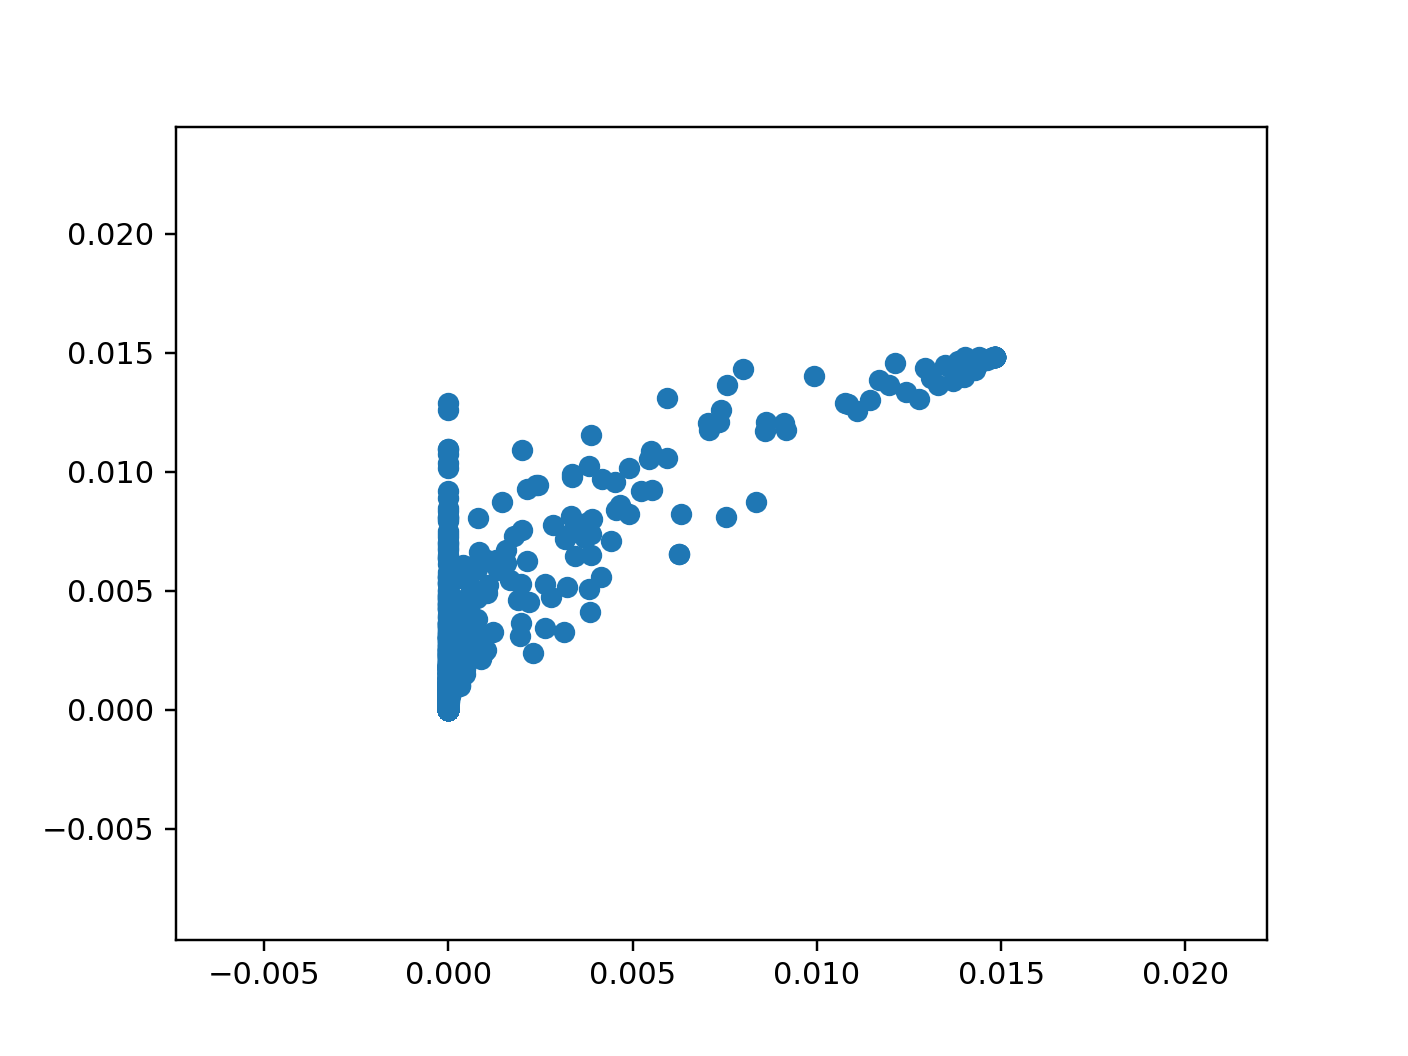

In [16]:
%matplotlib notebook
plt.scatter(msvds[sid].injections[0], msvds[sid].projections[0][np.asarray(output, dtype = int)])

In [ ]:
injection = msvds[sid].injection_mask.mask_volume(msvds[sid].experiments[list(msvds[sid].experiments.keys())[0]].get_injection(True))
projection = msvds[sid].projection_mask.mask_volume(msvds[sid].experiments[list(msvds[sid].experiments.keys())[0]].get_projection(True))

In [424]:
%matplotlib notebook

<IPython.core.display.Javascript object>


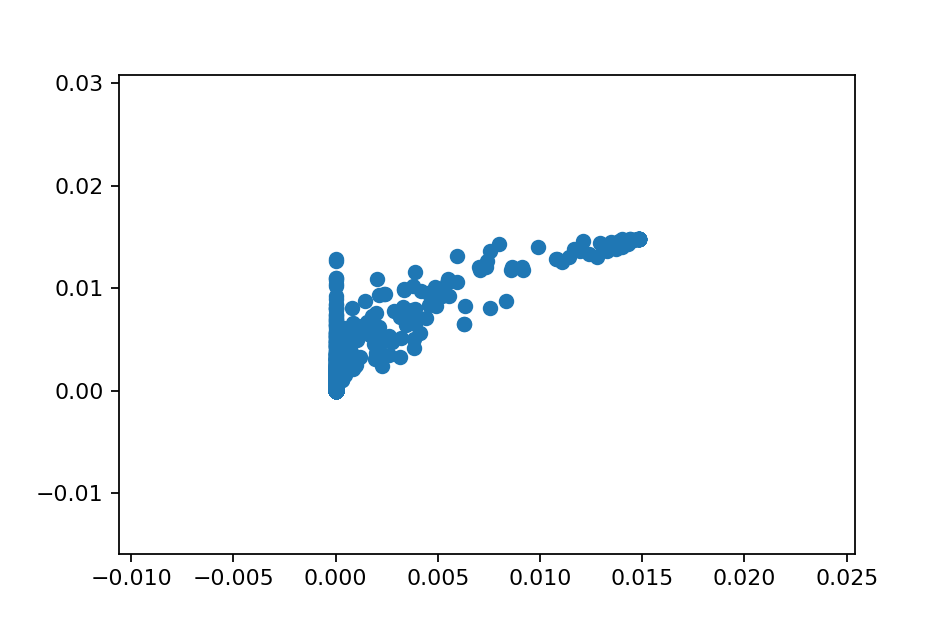

In [425]:
%matplotlib notebook
plt.scatter(msvds[sid].injections[0], msvds[sid].projections[0,np.asarray(output, dtype = int)])

In [427]:
msvds[sid].injection_mask.mask

1

In [428]:
msvds[sid].injection_mask.masked_shape

(10298,)

In [436]:
msvds[sid].experiments[list(msvds[sid].experiments.keys())[0]].get_injection(True).shape

(132, 80, 114)

In [ ]:
experiment = Experiment.from_cache(cache, eid)

In [ ]:
msvds[sid].injection_mask

In [447]:
injection = msvds[sid].injection_mask.mask_volume(msvds[sid].experiments[list(msvds[sid].experiments.keys())[0]].get_injection(True))
projection = msvds[sid].projection_mask.mask_volume(msvds[sid].experiments[list(msvds[sid].experiments.keys())[0]].get_projection(True))

<IPython.core.display.Javascript object>


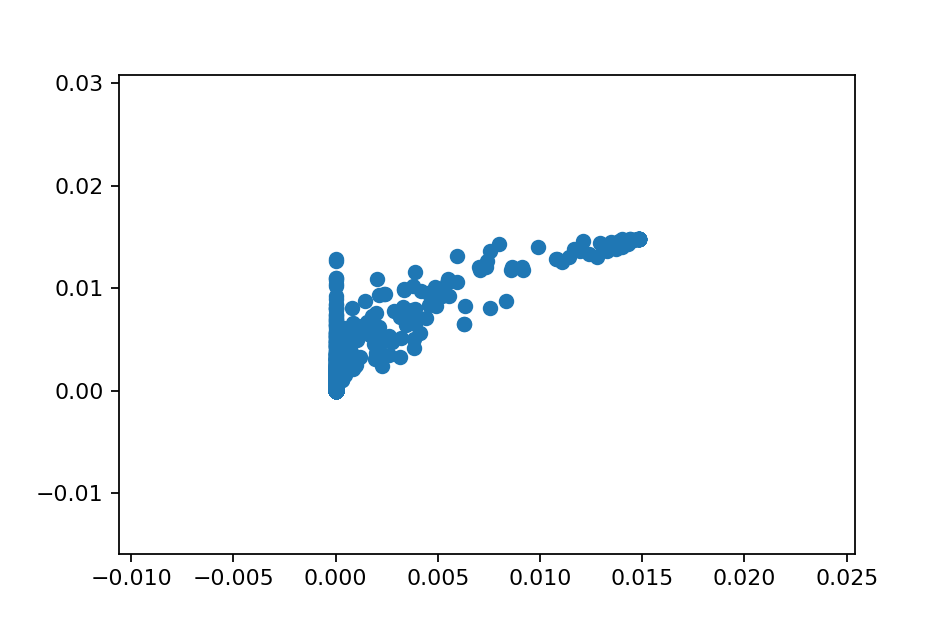

In [448]:
%matplotlib notebook
plt.scatter(injection, projection[np.asarray(output, dtype = int)])

In [401]:
i = 8644

In [402]:
np.where((vals2[:,0] == vals1[i,0]) & (vals2[:,1] == vals1[i,1]) & (vals2[:,2] == vals1[i,2]))

(array([238766]),)

In [399]:
np.where((vals2[:,0] == vals1[i,0]) & (vals2[:,1]==vals1[i,1]) & (vals2[:,2]==vals1[i,2]))[0]

array([238766])

In [392]:
np.where((vals2[:,0] == vals1[i,0]) & (vals2[:,1]==vals1[1,1]) & (vals2[:,2]==vals1[1,2]))[0]

array([], dtype=int64)

In [386]:
np.where((msvds[sid].projection_mask.coordinates == msvds[sid].injection_mask.coordinates).all(1))[0]

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


AttributeError: 'bool' object has no attribute 'all'

In [390]:
(msvds[sid].projection_mask.coordinates == msvds[sid].injection_mask.coordinates)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [385]:
np.where((msvds[sid].projection_mask.coordinates == msvds[sid].injection_mask.coordinates).all(1))[0]

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


AttributeError: 'bool' object has no attribute 'all'

In [372]:
np.hstack([msvds[sid].injections[0:1].transpose(), msvds[sid].injection_mask.coordinates])

array([[ 0., 56., 43., 59.],
       [ 0., 56., 43., 60.],
       [ 0., 56., 43., 61.],
       ...,
       [ 0., 90., 37., 82.],
       [ 0., 90., 38., 82.],
       [ 0., 90., 39., 82.]])

In [354]:
msvds[sid].injections[0].max()

0.014824019

In [339]:
rgba_colors

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.62148782e-05]])

In [337]:
msvds[sid].projections[0]

array([0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
       0.000000e+00, 4.621488e-05], dtype=float32)

In [331]:
msvds[sid].projections[0].shape

(448962,)

(448962, 3)

For every point in our training set, we can put an optimization probelm, where $v(i)$ is the creline and $c(i)$ is the centroid of experiment $i$.
\begin{eqnarray*}
\arg \min_{\xi ( v(i), v(i')) \geq 0 } \| y_i - \sum_{i' \in N_i} \xi ( v(i), v(i')) \omega (c(i), c(i')) y_{i'}  \|_2^2
\end{eqnarray*}

or the combined problem
\begin{eqnarray*}
\arg \min_{\xi_{vv'} \geq 0 } &\sum_{i} \| y_i - \sum_{i' \in N_i} \xi ( v(i), v(i')) \omega (c(i), c(i')) y_{i'}  \|_2^2 \\
&= \sum_{i \in V_l} \| y_i - (\xi_i \cdot \omega (c_i)) y_{N_i}  \|_2^2 \\
&= \sum_{i\in V_l} \| y_i - \xi_i  ( \omega (c_i) \cdot y_{N_i} ) \|_2^2 \\
&= \sum_{i\in V_l} \| y_i - ( I_i \omega (c_i) \cdot y_{N_i} ) \|_2^2 
\end{eqnarray*}
where $I_i \in \mathbb R^{V \times N_i}$ is the matrix with $1$ if the $i'th$ neighbor belongs to the $lth$ cre group.
note that $\|y_i - w_{i}^T y_{N_i}  \|$ has one or two parameters per combination, and so can't be fit.  Anyway, we get one of these problems for each creline structure combination.


In [ ]:

As an alternative approach, we can estimate a cre similarity within a structure (set of indices) by the l2 loss between their predictions.  These are essentially residuals in the 'one structure nw' sense.  The following boxplots show projection into various summary structures from VISp, colored by creline. For each creline, we can create a compute the $l2$ loss of its mean (or its mean $l2$ loss) compared with the other cre lines.

A cre-specific fixed effect is another option.  However, we expect the effect to be multiplicative. However, a fixed effect on the log scale raises the issue of zeros.  In scRNAseq it would just be like -15 or something. Amazon would use a shifted gamma for this business.

A critical issue is lack of experiments of certain cre lines in certain structures.

We need to plot and cluster. Make a plot with l2-loss.  Color bar based on same or different structure.  Color nodes based on cre line, shape based on structure.

Plot nmf regions by components heatmap.

In [5]:
#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)

In [216]:
a = 0
for i in range(12):
    a += list(experiments_minor_structures.values())[i].shape[0]

In [217]:
a

1751

In [212]:
len(list(experiments_minor_structures.values()))

12

In [19]:
ipsi_targetkey.shape

(448962,)

In [ ]:
#to do NW on residuals, need all predictions, not just out of sample.

In [13]:
sid = 315
data_merged = pd.DataFrame(np.hstack([np.expand_dims(creline[sid],1),msvds[sid].reg_proj_vcount_norm_renorm]))


In [22]:
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

In [49]:
data_merged = pd.DataFrame(np.hstack([np.expand_dims(creline[sid],1),msvds[sid].reg_proj_vcount_norm_renorm ]), columns = np.append(['cre'],colnames))
data_melted = pd.melt(data_merged, id_vars='cre')

In [50]:
data_melted

,cre,variable,value
0,Rbp4-Cre_KL100,FRP,0.0004548
1,Nr5a1-Cre,FRP,0.00513135
2,Sim1-Cre_KJ18,FRP,0.0662649
3,Efr3a-Cre_NO108,FRP,0.0136976
4,Cux2-IRES-Cre,FRP,0.0239754
...,...,...,...
650851,Efr3a-Cre_NO108,DN,0.00116575
650852,Slc17a8-IRES2-Cre,DN,2.14706e-05
650853,C57BL/6J,DN,0.000177024
650854,Tlx3-Cre_PL56,DN,0.0247222


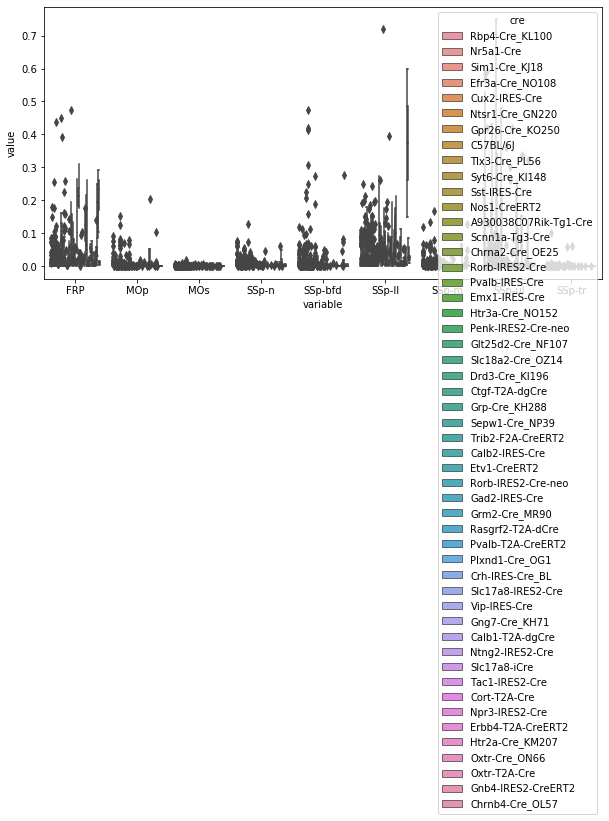

In [57]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
sns.boxplot(x="variable", y="value", hue="cre", data=data_melted[:10000], ax = ax)
#sns.boxplot(x = data_melted['variable'][:10000], y = data_melted['value'][:10000], c= np.asarray(data_melted['cre'][:10000], dtype = object), ax=ax)

In [170]:
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['variable', 'cre'])['value'].mean().reset_index()
    means_cast = pd.pivot_table(means, index = 'cre', columns = 'variable')
    means_cast.columns = means_cast.columns.get_level_values(1)
    #means_cast.index = means_cast.index.get_level_values(1)
    #sns.boxplot(x = creline[sid][es[sid]], y = ls[sid][gs[m,0]], ax=ax, order = order)

In [229]:
major_structure_ids

[512, 703, 1089, 1097, 315, 313, 354, 698, 771, 803, 477, 549]

In [227]:
st.ancestor_ids([ontological_order[i]])

[[1057, 315, 695, 688, 567, 8, 997]]

In [272]:
output = np.empty(len(ontological_order), dtype = object)
for i in range(len(ontological_order)):
    output[ i] = ia_map[np.intersect1d(st.ancestor_ids([ontological_order[i]]), major_structure_ids)[0]]

In [273]:
major_ontoloogy = output

In [274]:
major_ontoloogy

array(['Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'OLF', 'OLF', 'OLF', 'OLF',
       'OLF', 'OLF', 'OLF', 'OLF', 'OLF', 'OLF', 'OLF', 'HPF', 'HPF',
       'HPF', 'HPF', 'HPF', 'HPF', 'HPF', 'HPF', 'HPF', 'HPF', 'HPF',
       'HPF', 'CTXsp', 'CTXsp', 'CTXsp', 'CTXsp', 'CTXsp', 'CTXsp',
       'CTXsp', 'STR', 'STR', 'STR', 'STR', 'STR', 'STR', 'STR', 'STR',
       'STR', 'STR', 'STR', 'STR', 'STR', 'STR', 'PAL', 'PAL', 'PAL',


In [225]:
np.unique(np.asarray([st.parent_id([ontological_order[i]]) for i in range(len(ontological_order))]))

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Function parent_id is deprecated. Use SimpleTree.parent_ids instead.
  """Entry point for launching an IPython kernel.


array([   8,  343,  549,  567,  623,  688,  695,  997, 1065, 1097, 1129])

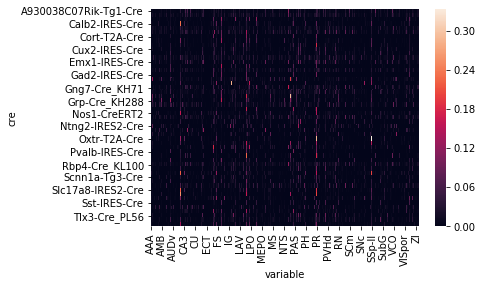

In [173]:
sns.heatmap(means_cast)

In [259]:
#networks = sns.load_dataset("brain_networks", index_col=0, header=[0, 1, 2])

major_pal = sns.cubehelix_palette(np.unique(major_ontoloogy).size,
                                    light=.9, dark=.1, reverse=True,
                                    start=1, rot=-2)
major_lut = dict(zip(map(str, np.unique(major_ontoloogy)), major_pal))

major_colors = pd.Series(major_ontoloogy).map(major_lut)

In [283]:
major_colors.index = means_cast.columns

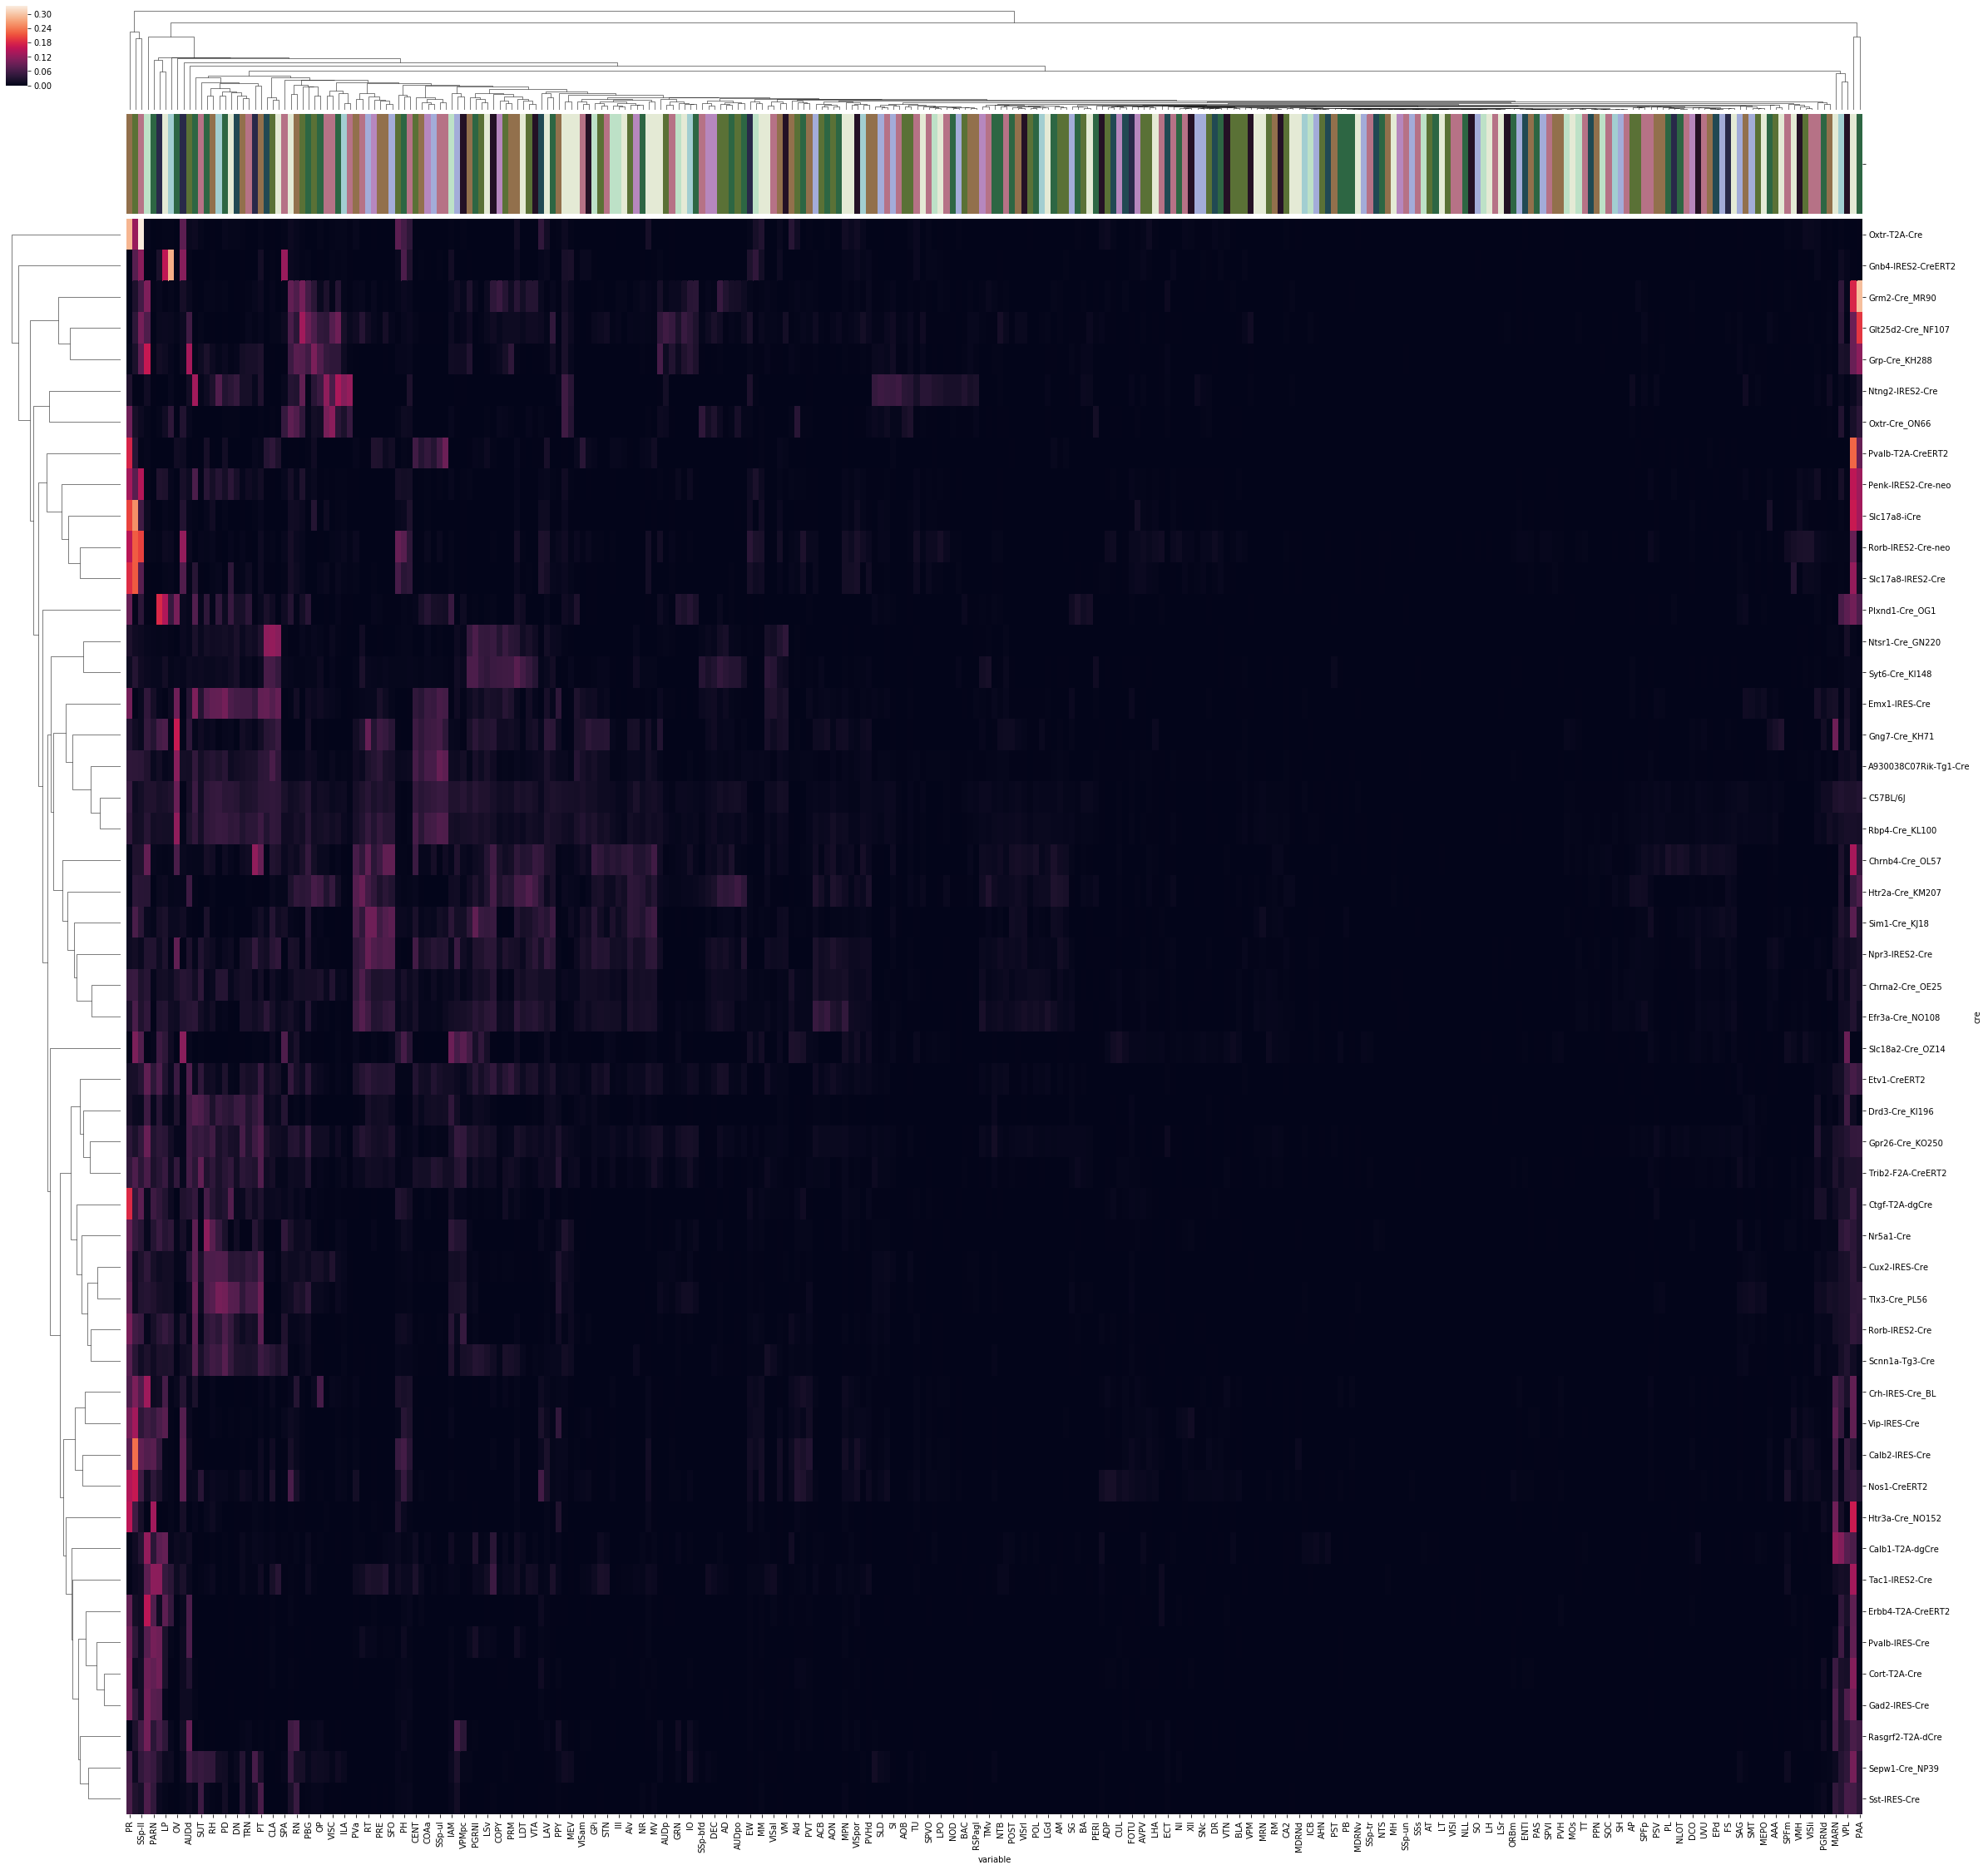

In [290]:
#cluster y and color code by major division
#fig, ax = plt.subplots(1,1, figsize = (40,40))
sns.clustermap(means_cast,row_cluster= True, col_cluster = True, col_colors=major_colors,figsize = (40,40))

In [301]:
np.asarray(np.where(lmc == -np.inf)).trnapos

array([[  2,   2,   2, ...,  50,  50,  50],
       [  0,  13,  15, ..., 263, 265, 271]])

In [305]:
np.asarray(lmc)[np.asarray(np.where(lmc == -np.inf))]

IndexError: index 67 is out of bounds for axis 0 with size 51

In [310]:
lmc = np.log(np.asarray(means_cast))
lmc[np.where(lmc < -8)] = -8
lmc = pd.DataFrame(lmc, columns = means_cast.columns, index = means_cast.index)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


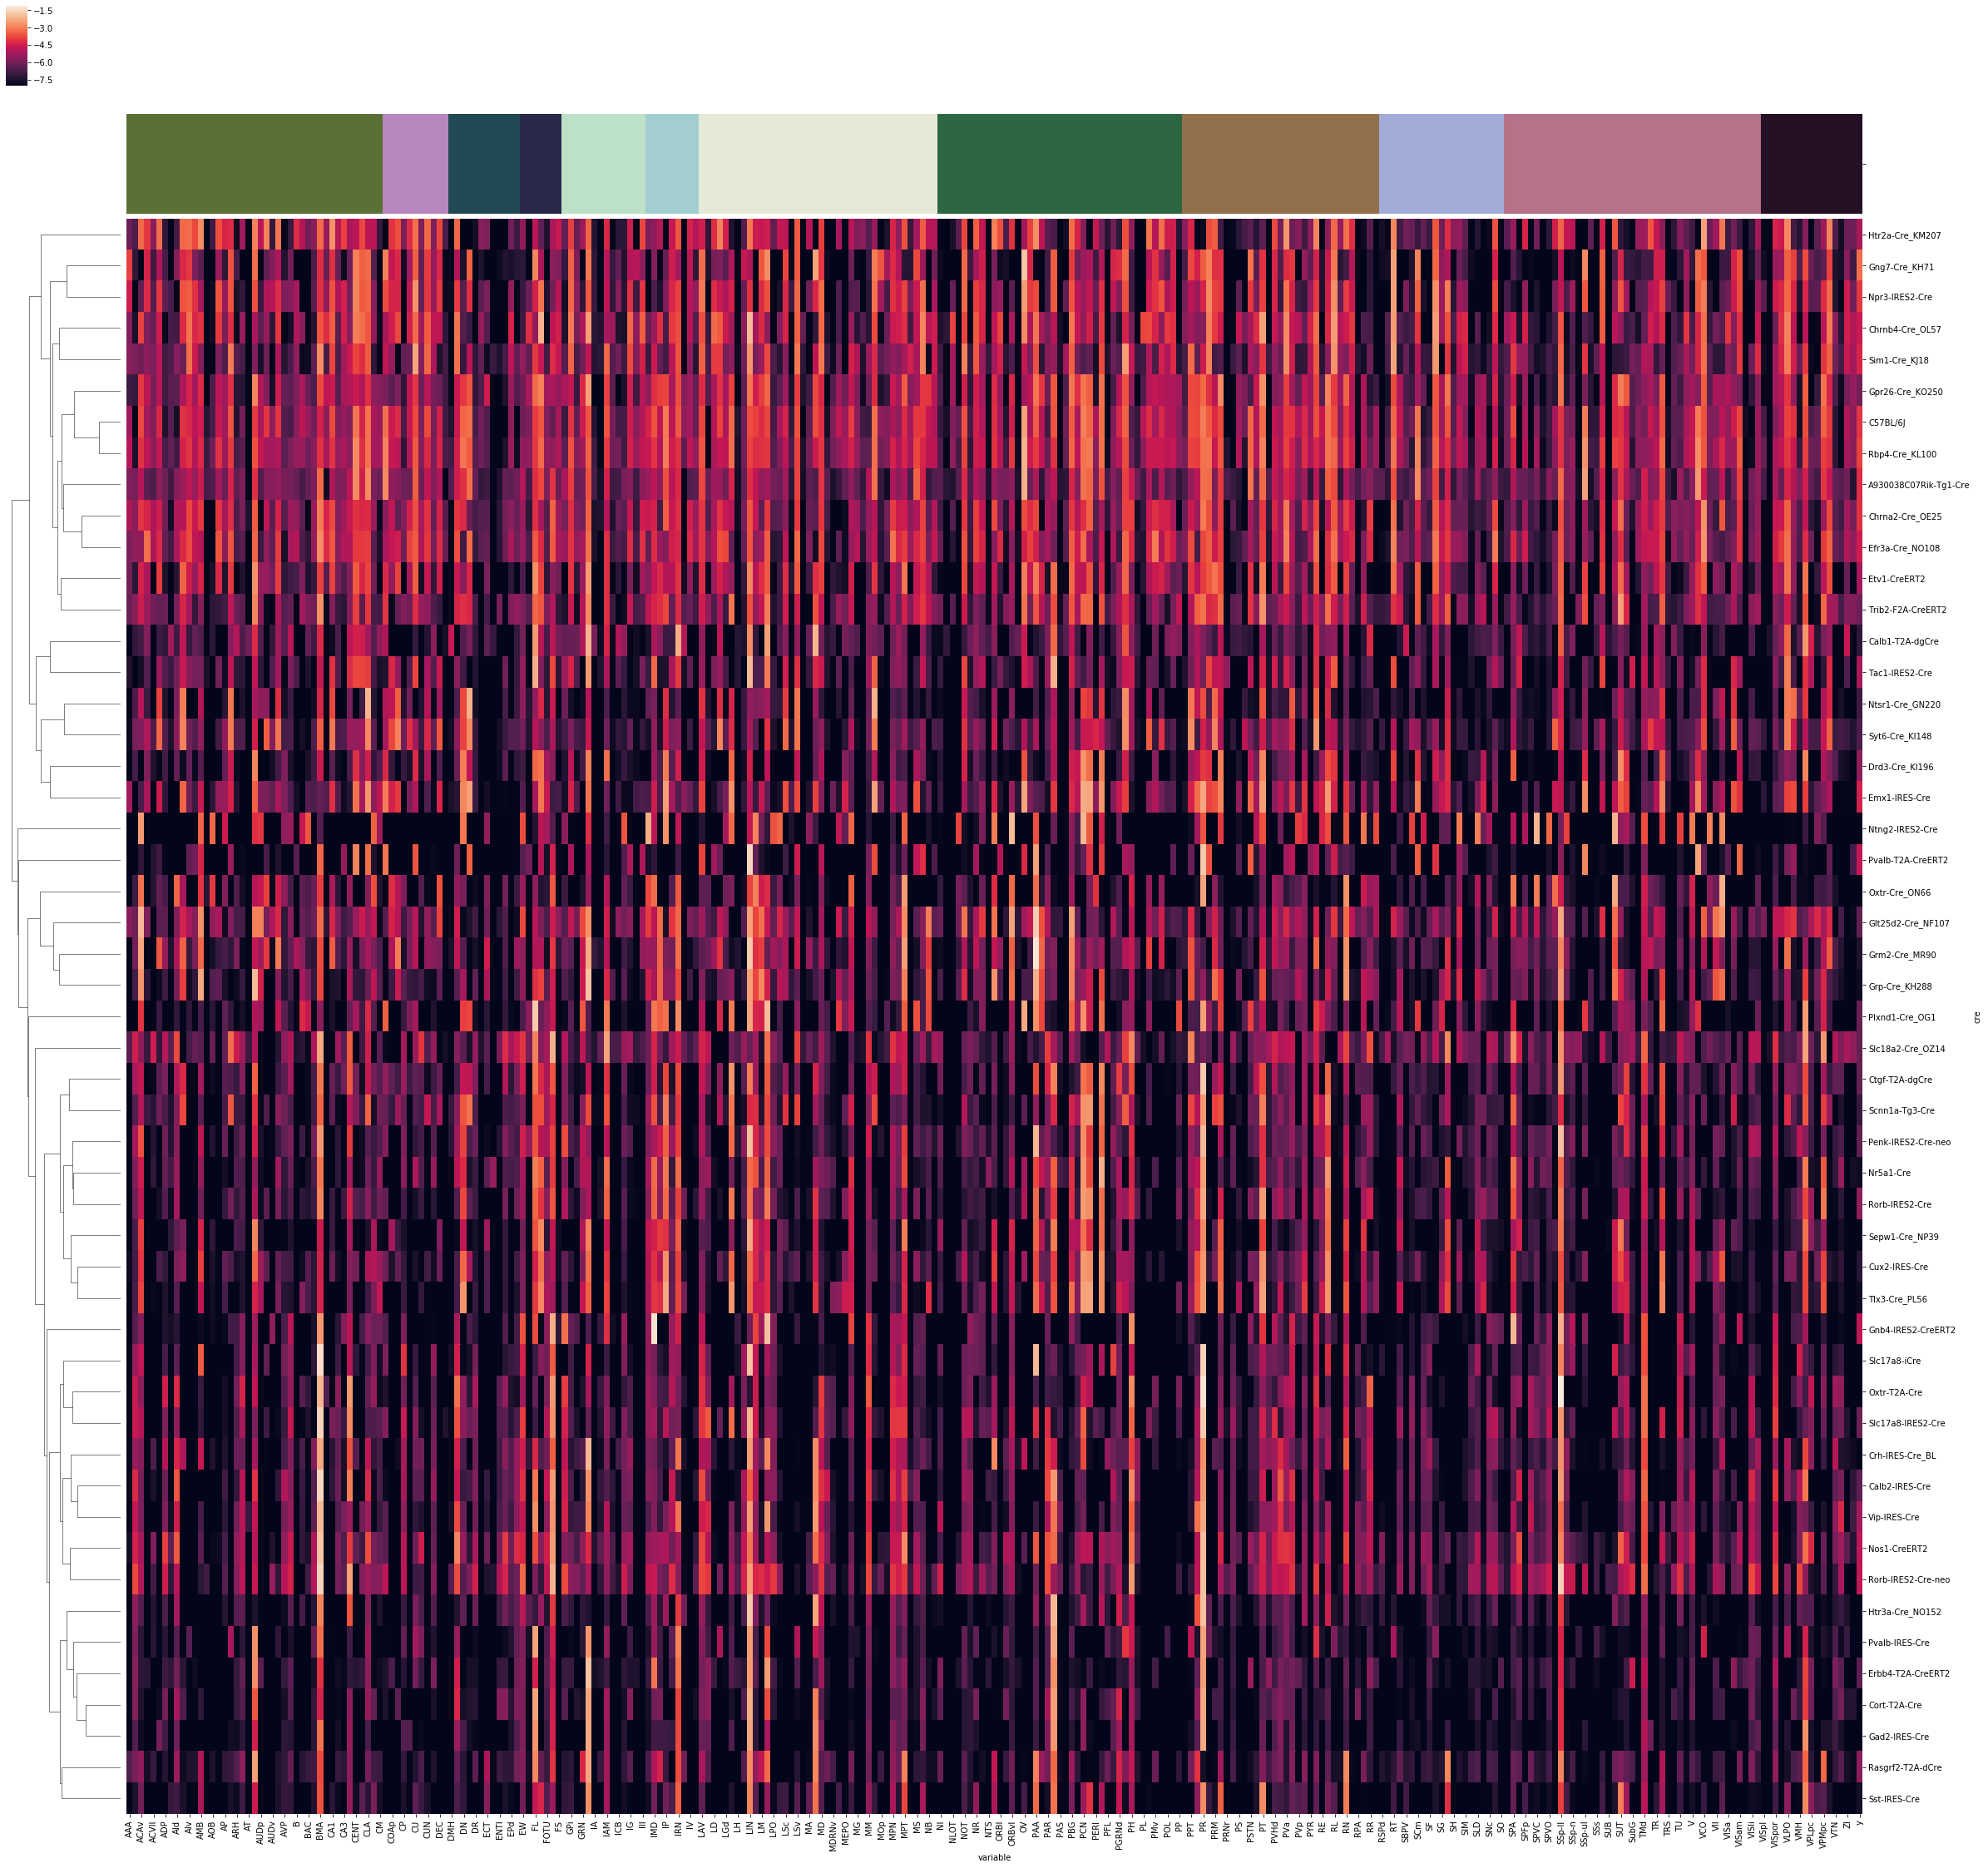

In [312]:
sns.clustermap(lmc,row_cluster= True, col_cluster = False, col_colors=major_colors,figsize = (40,40))

In [314]:
msvds[sid].projections.shape

(1128, 448962)

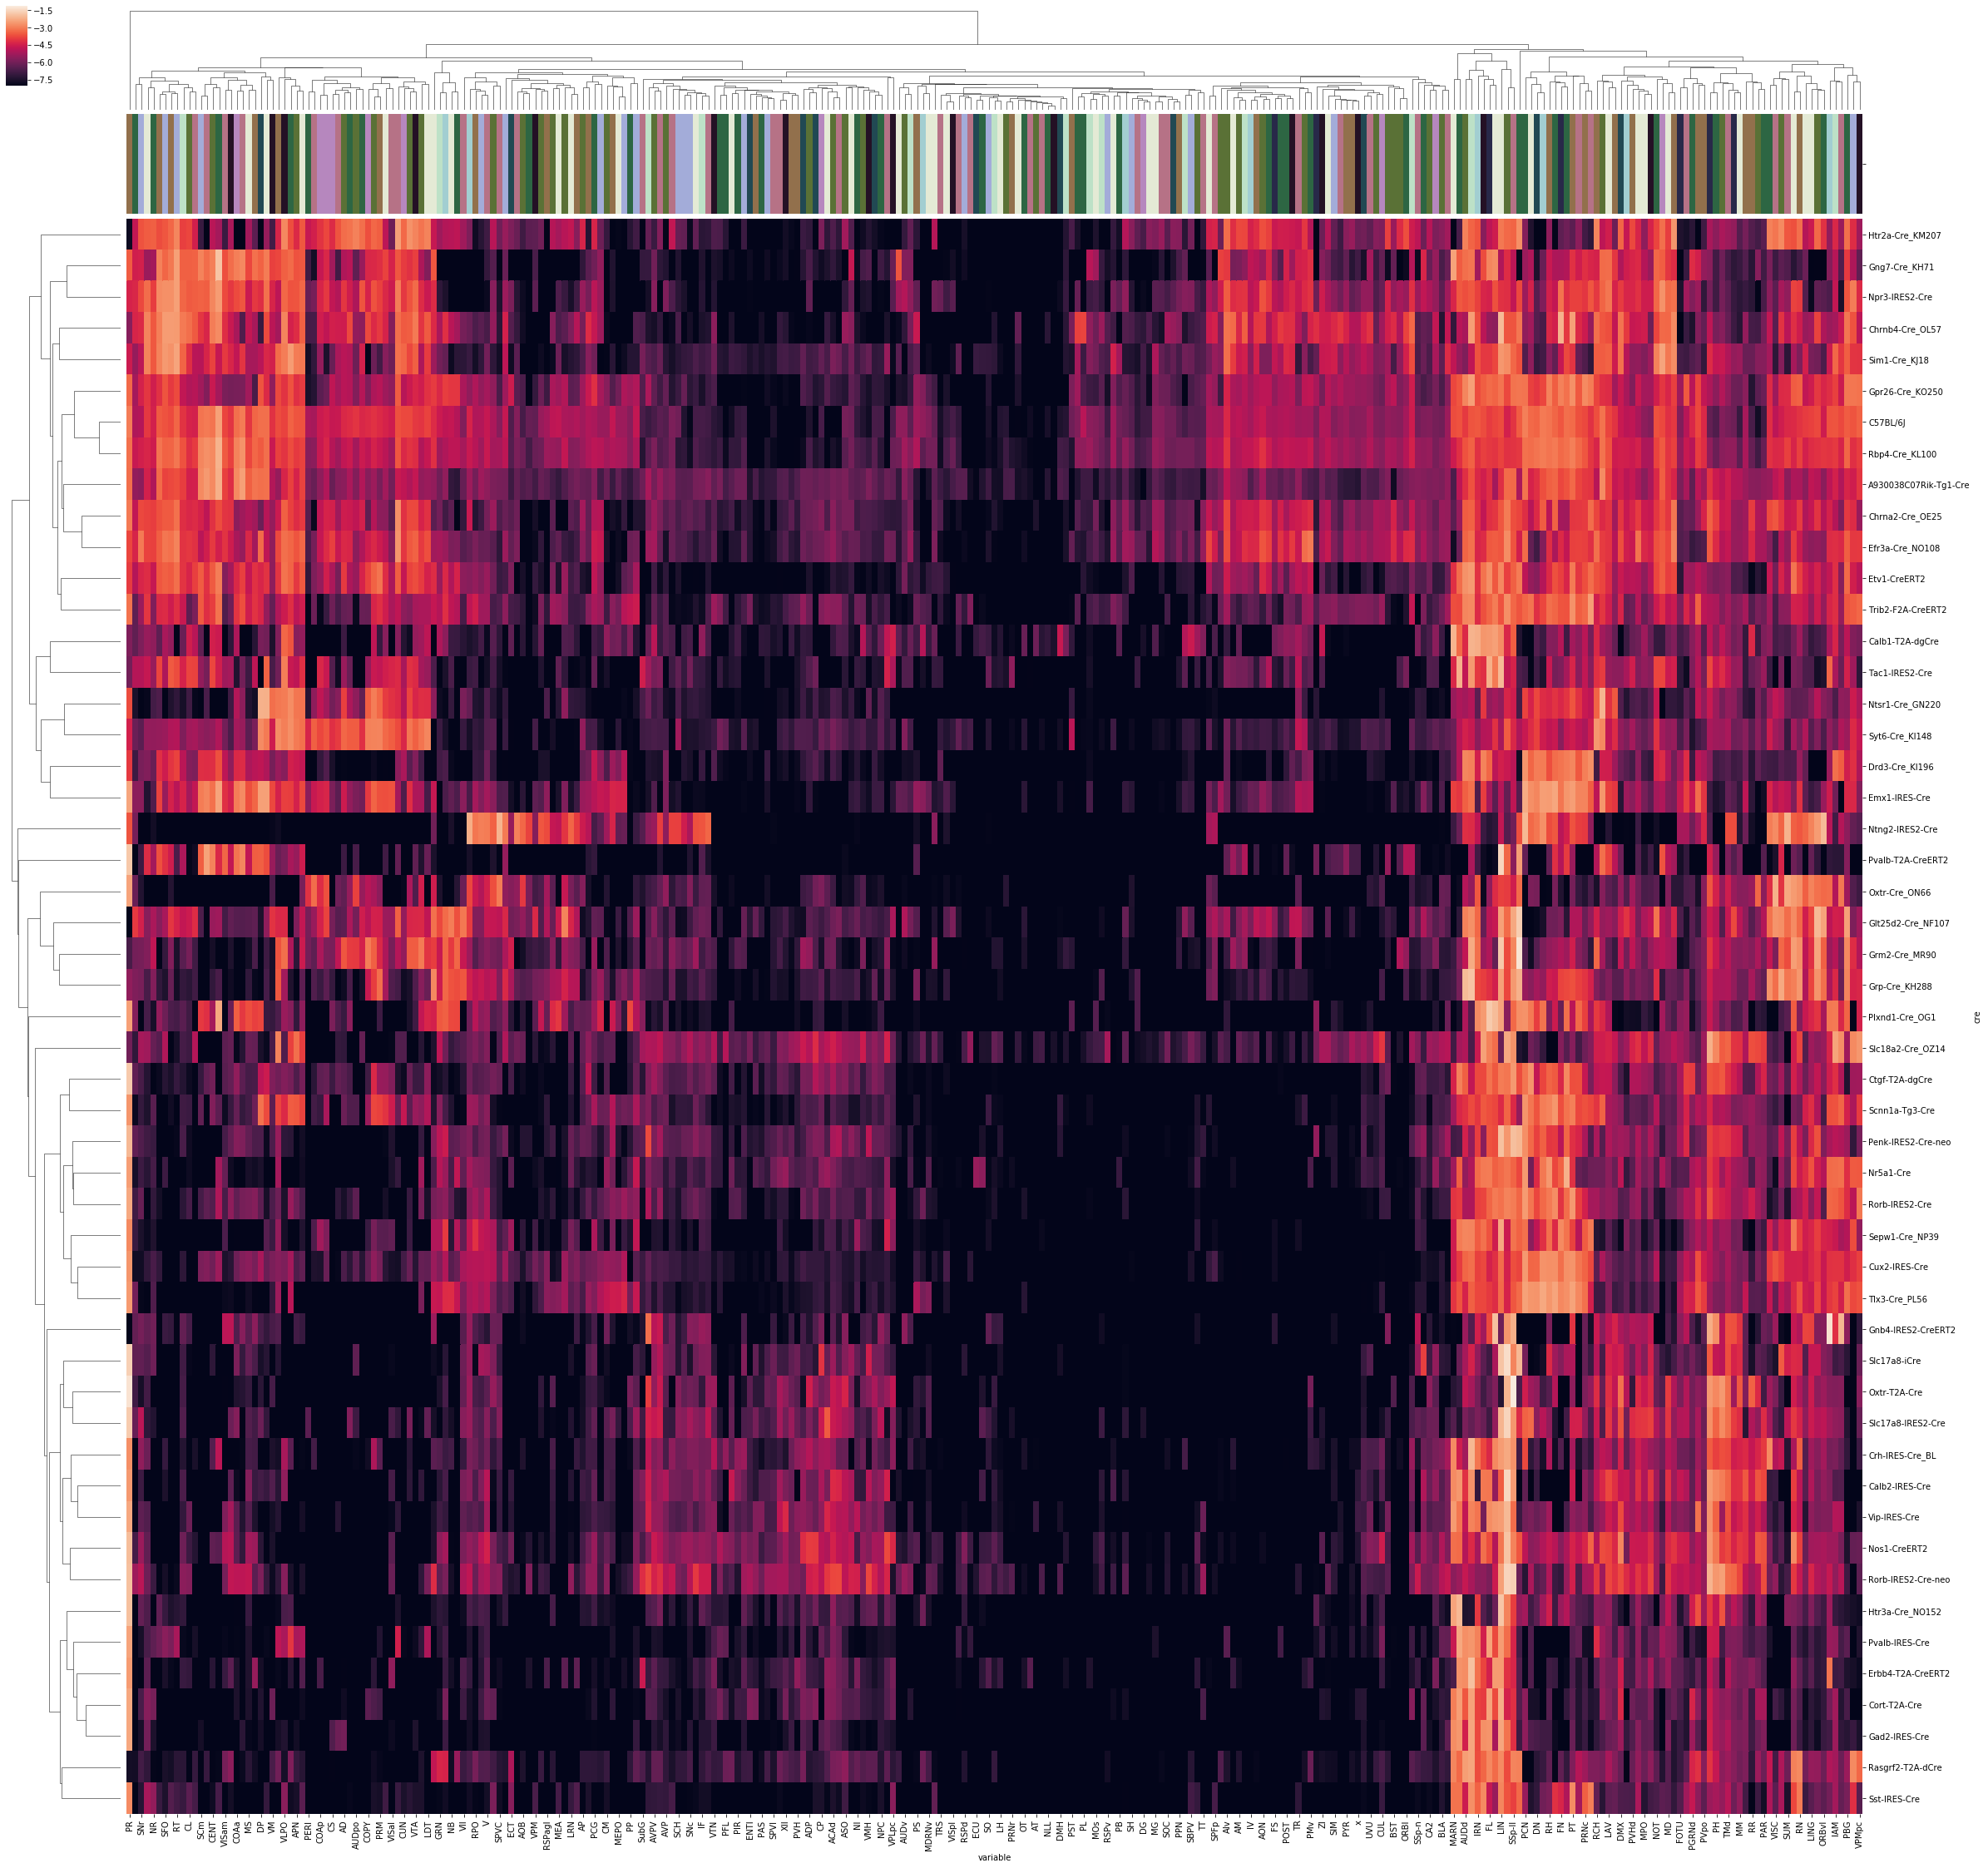

In [311]:
sns.clustermap(lmc,row_cluster= True, col_cluster = True, col_colors=major_colors,figsize = (40,40))

In [263]:
help(sns.clustermap)

Help on function clustermap in module seaborn.matrix:

clustermap(data, pivot_kws=None, method='average', metric='euclidean', z_score=None, standard_scale=None, figsize=None, cbar_kws=None, row_cluster=True, col_cluster=True, row_linkage=None, col_linkage=None, row_colors=None, col_colors=None, mask=None, **kwargs)
    Plot a matrix dataset as a hierarchically-clustered heatmap.
    
    Parameters
    ----------
    data: 2D array-like
        Rectangular data for clustering. Cannot contain NAs.
    pivot_kws : dict, optional
        If `data` is a tidy dataframe, can provide keyword arguments for
        pivot to create a rectangular dataframe.
    method : str, optional
        Linkage method to use for calculating clusters.
        See scipy.cluster.hierarchy.linkage documentation for more information:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    metric : str, optional
        Distance metric to use for the data. See
        

In [197]:
thing = NMF(n_components=20,l1_ratio  = 0.0, alpha  = 0.01)

In [198]:
toplot = thing.fit_transform(msvds[sid].reg_proj_vcount_norm_renorm.transpose())

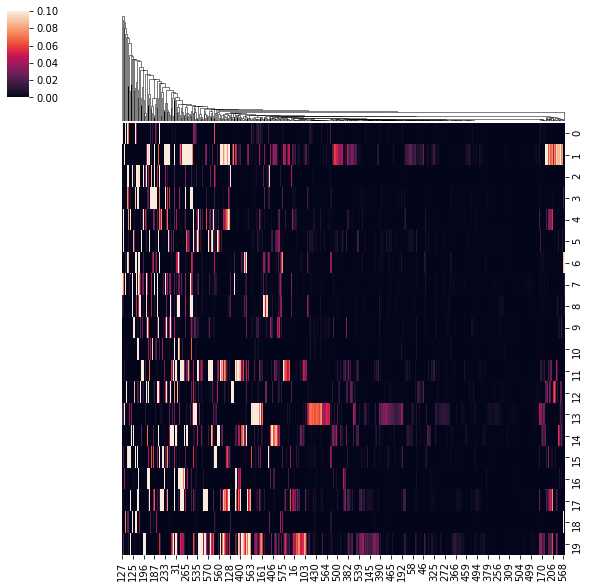

In [202]:
sns.clustermap(toplot.transpose(), vmax= .1, row_cluster = False)

In [ ]:
#nmf projections

In [149]:
pd.DataFrame(means)

value
variable cre                            
AAA      A930038C07Rik-Tg1-Cre  0.003094
         C57BL/6J               0.005649
         Calb1-T2A-dgCre        0.000000
         Calb2-IRES-Cre         0.000394
         Chrna2-Cre_OE25        0.006649
...                                  ...
y        Syt6-Cre_KI148         0.001317
         Tac1-IRES2-Cre         0.005838
         Tlx3-Cre_PL56          0.000420
         Trib2-F2A-CreERT2      0.002341
         Vip-IRES-Cre           0.005569

[14841 rows x 1 columns]

In [ ]:
#most correlated regions... most correlated experiments
#log scale

In [129]:
data_melted.groupby(by=['variable'])['value']

In [123]:
data_melted.columns

Index(['cre', 'variable', 'value'], dtype='object')

In [ ]:
#heatmap mean by line

In [186]:
from sklearn.decomposition import NMF

In [64]:
import scipy

In [67]:
#thing.fit_transform(scipy.stats.ortho_group.rvs(2))

In [106]:
thing = NMF(n_components=2, alpha = 0.)

In [444]:
msvds[sid]

In [443]:
thing.fit_transform(msvds[sid].reg_proj_vcount_norm_renorm)

AttributeError: 'VoxelDataset' object has no attribute 'reg_proj_vcount_norm_renorm'

In [441]:
thing = NMF(n_components=2, alpha = 0.0001)

In [442]:
thing.fit_transform(np.asarray([[1,0],[0,0.5]]))

array([[0.99990384, 0.        ],
       [0.        , 0.70697579]])

In [ ]:
thing.fit_transform(np.identity(2))

In [11]:
creline[sid].shape

(1128,)

In [10]:
msvds[sid].reg_proj_vcount_norm_renorm.shape

(1128, 577)

In [ ]:
ls = losses_leaf_leaf2wt#losses_wtleaf_leaf2#losses_goodcreleaf_wtleaf2
gs = best_gamma_leaf_leaf2wt
es= eval_indices_leaf2ormore_wt
%matplotlib inline
nms = len(major_structure_ids)
fig, ax = plt.subplots(1,1, figsize = (80,50))
for m in range(4,5):
    print(m)
    sid = major_structure_ids[m]
    losses_bycre = pd.DataFrame(np.asarray([ls[sid][gs[m,0]], creline[sid][es[sid]]]).transpose())
    losses_bycre = losses_bycre.astype({0: np.float64})
    order = np.unique(losses_bycre[1])[losses_bycre.groupby(by=[1])[0].mean().argsort()]
    sns.boxplot(x = creline[sid][es[sid]], y = ls[sid][gs[m,0]], ax=ax, order = order)
    #axes[m,1].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = 35)
    #axes[m,0].set_xl
    ax.tick_params(axis='y', which='major', labelsize=30)
    ax.set_ylabel(major_structures[m], fontsize = 60)

    ax.set_title('Voxel-loss', fontsize = 60)
plt.tight_layout() 
plt.savefig('/Users/samsonkoelle/justsaveit')

In [118]:
losses_bycre = pd.DataFrame(np.asarray([ls[sid][gs[m,0]], creline[sid][es[sid]]]).transpose())

NameError: name 'ls' is not defined